<a href="https://colab.research.google.com/github/theKirill/GensimSample/blob/master/google_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификатор на основе модели от Google

Модель:
*  https://github.com/mmihaltz/word2vec-GoogleNews-vectors

In [1]:
from gensim.models import KeyedVectors
from keras.layers.core import Dense, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import collections
import nltk
import numpy as np
import codecs
import pandas as pd
import gensim
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Activation
from keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import save_model, load_model
from keras.callbacks import ModelCheckpoint
from nltk.tokenize import RegexpTokenizer

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def tokenize(text):
  regex_tokenizer = RegexpTokenizer('[a-zA-Z]+')
  words = regex_tokenizer.tokenize(text.lower())
  stop_words = set(stopwords.words("english"))
  without_stop_words = [w for w in words if w not in stop_words]
  return without_stop_words

In [0]:
# Преобразование номеров классов в названия классов
def transform_from_categorical(prediction, intents):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(intents[prediction[i]])

  return answers

# Преобразование названий классов в матрицу двоичных чисел (нужно для keras)
def transform_to_categorical(intents_for_each, unique_intents):
  intents_to_digit = []

  for intent in intents_for_each:
    intents_to_digit.append(unique_intents.index(intent))

  return to_categorical(intents_to_digit, len(unique_intents))

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Загрузка данных и модели от Google

In [17]:
file_csv = pd.read_csv('drive/My Drive/ForGensim/train.csv')
word2vec_model = KeyedVectors.load_word2vec_format(
    "drive/My Drive/ForGensim//2GoogleNews-vectors-negative300.bin.gz",
    binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
EMBED_SIZE = 300
NUM_FILTERS = 256
NUM_WORDS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 10

In [0]:
counter = collections.Counter()

Просмотрели некоторые слова в словаре

In [20]:
from itertools import islice
list(islice(word2vec_model.vocab, 15010, 15020))

['John_F._Kennedy',
 'ideals',
 'insane',
 'Dow_Jones_Industrial_Average',
 'Guillen',
 'Established',
 'lip',
 'SS',
 'Drop',
 'prominence']

Работа с набором данных (удаление стоп-слов, получение частотного словаря, максимальной длины)

In [0]:
all_texts = file_csv['text']
all_intents = file_csv['intents']

In [0]:
sentences = np.array(all_texts.apply(lambda x : tokenize(x)))

In [0]:
#считаем максимальную длину предложений, а также частоту всех слов предложений, считанных из файла 
maxlen = 0
for words in sentences:
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1

Подготовка данных для обучения на основе модели от Google

In [0]:
vocab_sz = len(counter) + 1

In [0]:
# Создание единого словаря (слово -> число) для преобразования на основе списка текстов sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [0]:
X =  tokenizer.texts_to_sequences(sentences) #заменяем слова каждого предложения на числа

In [40]:
X[:3]

[[2, 167, 18, 3872, 984, 1155, 3],
 [2, 1741, 868, 3, 786, 35, 197, 106, 500],
 [2, 285, 1742, 2401, 1156]]

In [0]:
y = transform_to_categorical(all_intents, all_intents.unique().tolist())#заменяем названия интентов на матрицу двоичных чисел

In [42]:
y[:3]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
X = pad_sequences(X, maxlen = maxlen) #уравниваем все предложения до размера maxlen

In [44]:
X[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    2,  167,   18, 3872,  984, 1155,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    2, 1741,  868,    3,  786,   35,  197,  106,  500],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    2,  285, 1742, 2401, 1156]],
      dtype=int32)

In [114]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9099, 22) (2275, 22) (9099, 5) (2275, 5)


Создание keras модели

In [0]:
embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))

In [47]:
embedding_weights

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))#создаём матрицу размером размерность словаря*размерность вектора слова
index = 0
sorted_counter = counter.most_common() #сортируем слова по частоте встречаемости
for word in sorted_counter:#для каждого слова из нашего словаря задаём вектор из word2vec_model в матрицу
    try:
      embedding_weights[index, :] = word2vec_model[word[0]] 
      index+=1     
    except KeyError:#если нет слова в словаре word2vec_model
      index+=1
      pass

In [0]:
COUNT_CLASSES = all_intents.unique().shape[0]

In [0]:
# Создание модели
def get_model(COUNT_CLASSES, embedding_weights):
  model = Sequential()
  model.add(Embedding(vocab_sz, EMBED_SIZE, input_length = maxlen,
                      weights = [embedding_weights],
                      trainable = True))
  model.add(SpatialDropout1D(0.2))
  model.add(Conv1D(filters = NUM_FILTERS, kernel_size = NUM_WORDS,
                  activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(COUNT_CLASSES, activation="softmax"))

  model.compile(optimizer = "adam", loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  
  return model

In [110]:
keras_model = get_model(COUNT_CLASSES, embedding_weights)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [111]:
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 300)           2773500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 22, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 256)           230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 3,005,441
Trainable params: 3,005,441
Non-trainable params: 0
_________________________________________________________________


Обучение keras модели

In [115]:
history = keras_model.fit(X_train, y_train, batch_size = BATCH_SIZE,
                    epochs = NUM_EPOCHS,
                    callbacks=[ModelCheckpoint('drive/My Drive/ForGensim/google_keras_model.h5', save_best_only = True)],
                    validation_split = 0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7279 samples, validate on 1820 samples
Epoch 1/10
7279/7279 [==============================] - 20s 3ms/step - loss: 0.3036 - acc: 0.9163 - val_loss: 0.0687 - val_acc: 0.9819
Epoch 2/10
7279/7279 [==============================] - 18s 2ms/step - loss: 0.0442 - acc: 0.9900 - val_loss: 0.0458 - val_acc: 0.9885
Epoch 3/10
7279/7279 [==============================] - 17s 2ms/step - loss: 0.0161 - acc: 0.9966 - val_loss: 0.0344 - val_acc: 0.9901
Epoch 4/10
7279/7279 [==============================] - 17s 2ms/step - loss: 0.0078 - acc: 0.9988 - val_loss: 0.0342 - val_acc: 0.9901
Epoch 5/10
7279/7279 [==============================] - 18s 2ms/step - loss: 0.0038 - acc: 0.9995 - val_loss: 0.0260 - val_acc: 0.9918
Epoch 6/10
7279/7279 [==============================] - 18s 2ms/step - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0265 - val_acc: 0.9929
Epoch 7/10
7279/7279 [========================

In [117]:
score = keras_model.evaluate(X_test, y_test)
print("Test accuracy: {:.3f}".format(score[1]))

2275/2275 [==============================] - 1s 221us/step
Test accuracy: 0.996


In [0]:
prediction = keras_model.predict_classes(X_test)

Модель обучилась с точностью ~99%

In [0]:
unique_intents = all_intents.unique().tolist()

In [0]:
y_test_ = []
y_test = y_test.tolist()
for i in range(len(y_test)):
  y_test_.append(unique_intents[y_test[i].index(1)])

In [0]:
prediction_ = transform_from_categorical(prediction, unique_intents)

In [0]:
import seaborn as sn

In [0]:
import matplotlib.pyplot as plt

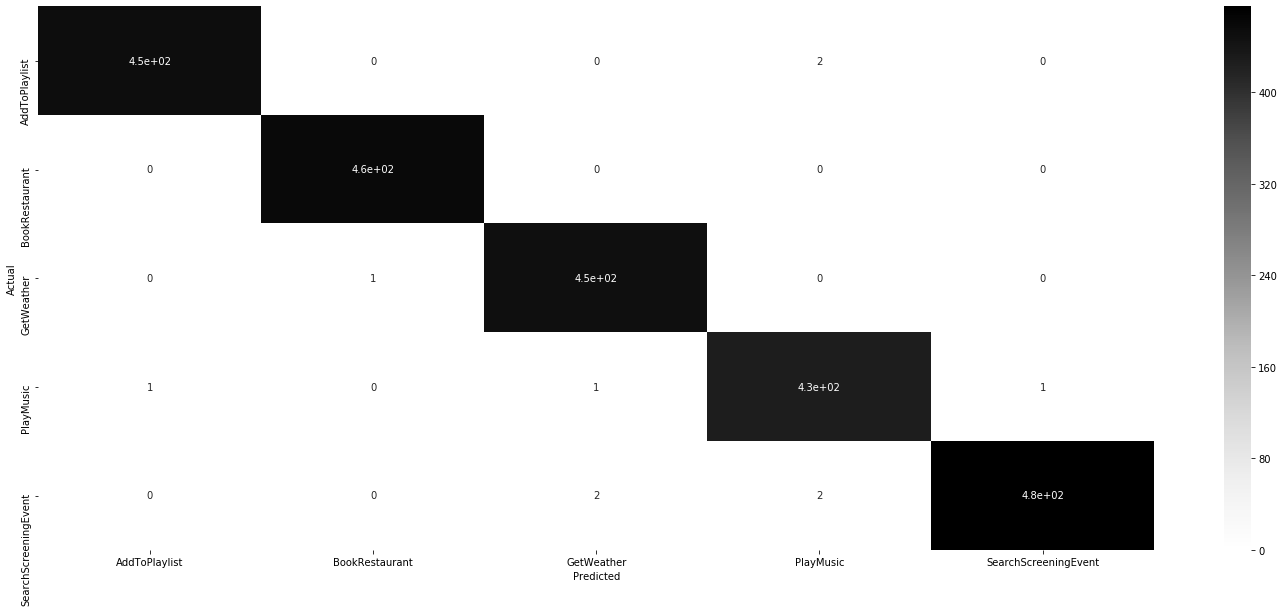

In [161]:
data = {'prediction': prediction_,
        'actual':    y_test_
        }

df = pd.DataFrame(data, columns = ['actual','prediction'])
confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames = ['Actual'], colnames = ['Predicted'])
plt.figure(figsize=(25, 10))
sn.heatmap(confusion_matrix, annot=True,cmap="Greys")

Как видно, наша модель мало ошибается, но иногда путает интенты `AddToPlayList` с `PlayMusic`, `SearchScreeningEvent` с `GetWeather`

# Тестирование (проверка работы) классификатора на небольших данных

In [0]:
test = ['Add track to my Digster Future Hits', 'what a temperature today in kirov', 'add to playlist my song my melody', 
        'What is the hottest temperature on earth right now?', 'Find a movie schedule for 12 hours from now', 'play ed sheeran song'] 

In [119]:
sequences_test = tokenizer.texts_to_sequences(test)
sequences_test

[[2, 21, 576, 617, 111],
 [572, 147],
 [2, 3, 18, 193],
 [572, 1039, 231],
 [13, 5, 17, 87],
 [1, 7325, 18]]

In [0]:
X_predict = pad_sequences(sequences_test, maxlen = maxlen)

In [0]:
prediction = keras_model.predict_classes(X_predict)

In [123]:
answers = transform_from_categorical(prediction, all_intents.unique().tolist()) 
answers

['AddToPlaylist',
 'GetWeather',
 'AddToPlaylist',
 'GetWeather',
 'SearchScreeningEvent',
 'PlayMusic']